- By: Harkishan Singh Baniya
- Email: harkishansinghbaniya@gmail.com
- Reference: Advances in Financial Machine Learning by Dr Marcos Lopez De Prado

This notebook is a part of article series **Alternative Bars on Alpaca** . In first part of the article I have explained how to generate *Alternative Bars*  i.e. `tick bar`, `volume bar` and `dollar bar` using Alpaca API. In this second part we will explore them and look at some of there statistical properties. <br>

The analysis will be performed on historical bars of AAPL (Apple) trades data from *Jan 1st 2018* to *Dec 31st 2019*. The sampling freqency/ thresholds of different bars are as follows.

- Tick Bars: 5,000 (ticks)
- Volume Bars: 700,000 (volume/qty)
- Dollar Bars: 150,000,000 (dollar)
- Time Bars: 5 (minute)


In [1]:
#Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style 

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

style.use('ggplot')

%matplotlib inline

In [2]:
#trim the after market data if any
def trim_df(df:pd.DataFrame):
    try:
        df = df.tz_localize('UTC').tz_convert('US/Eastern')
    except TypeError as e:
        df = df.tz_convert('US/Eastern')
    idx = df.index 
    c1 = (idx.time < dt.time(9, 30))
    c2 = (idx.time > dt.time(16, 0))
    df=df[~(c1|c2)]
    return df
#read data and store the bars in a dictionary
def read_data(symbol:str):
    path = 'sample_datasets/analysis/'
    bars = {}
    bars['time_bar'] = trim_df(pd.read_csv(path+f'{symbol}_5minute_bars.csv', index_col=[0], parse_dates=True))
    bars['tick_bar'] =  trim_df(pd.read_csv(path+f'{symbol}_tick_bars.csv', index_col=[0], parse_dates=True))
    bars['volume_bar'] =  trim_df(pd.read_csv(path+f'{symbol}_volume_bars.csv', index_col=[0], parse_dates=True))
    bars['dollar_bar'] =  trim_df(pd.read_csv(path+f'{symbol}_dollar_bars.csv', index_col=[0], parse_dates=True))
    return bars
AAPL = read_data(symbol='AAPL')

## Bar Count

In [3]:
#Bar Count Analysis and Plots
def show_bar_count(bars:dict, time_group='1D'):
    counts = {}
    f,ax=plt.subplots(figsize=(16,9))
    for bar in bars.keys():
        if bar != 'time_bar':
            df = bars[bar]
            count = df.groupby(pd.Grouper(freq=time_group))['close'].count()
            counts[bar] = count
            count.plot(ax=ax, ls='-', label=bar, alpha=0.8)
            print(f'The bar count for {bar} with time group {time_group} has a mean count of {count.mean()} and a standard deviation of {count.std()}')
    ax.legend()

The bar count for tick_bar with time group 1D has a mean count of 29.718792866941016 and a standard deviation of 25.044996663634983
The bar count for volume_bar with time group 1D has a mean count of 25.685871056241428 and a standard deviation of 21.890620465954125
The bar count for dollar_bar with time group 1D has a mean count of 23.403292181069958 and a standard deviation of 19.47185317502504


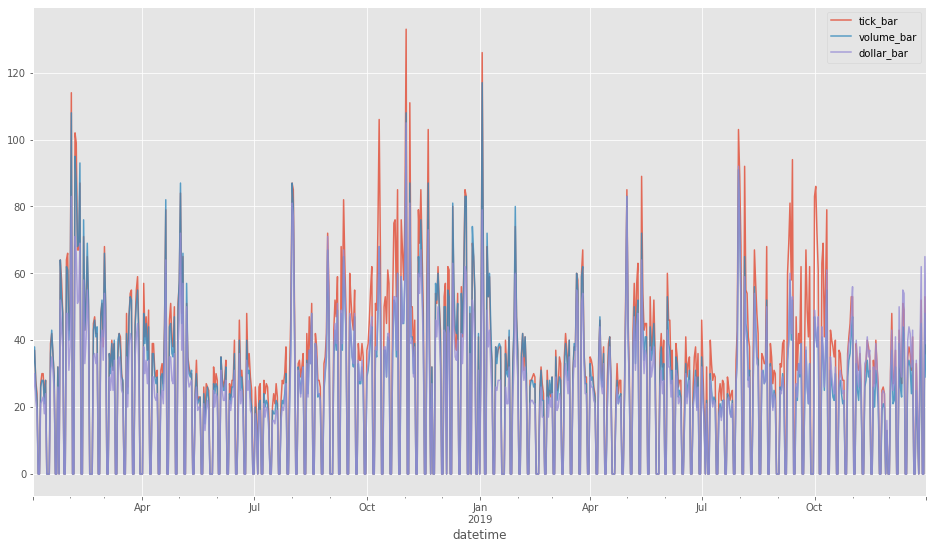

In [4]:
show_bar_count(AAPL)

Bars are sample with threholds chossen arbitarily that gives a bar count between 25-30 bars per day. Overall bar counts are most stable for dollar bars since it has the least deviation from the mean count, while tick bars has a high deviation. 

## Comparing with Time Bars Sampling

In [5]:
def plot_bars(bars:dict, date:str='2019-08-07'):
    time_bar = bars['time_bar'].close.loc[date].tz_convert('UTC')
    tick_bar = bars['tick_bar'].close.loc[date]
    volume_bar = bars['volume_bar'].close.loc[date]
    dollar_bar = bars['dollar_bar'].close.loc[date]
    
    fig, ax = plt.subplots(figsize=(18,12))
  
    no_lable = False
    for timestamp in time_bar.index:
        if not no_lable:
            plt.axvline(x=timestamp, label='time bar', color='blue', linestyle='--', linewidth=0.7)
            no_lable=True
        else:
            plt.axvline(x=timestamp, color='blue', linestyle='--', linewidth=0.7)
    tick_bar.plot(ax=ax, label='tick bar', ls='', marker='D', color='yellow', alpha=0.5)
    volume_bar.plot(ax=ax, label='volume bar', ls='', marker='o', color='purple', alpha=0.5)
    dollar_bar.plot(ax=ax, label='dollar bar', ls='', marker='*', color='red', alpha=0.5)
    ax.legend() 
    plt.title(f'Bar plots for {date}')


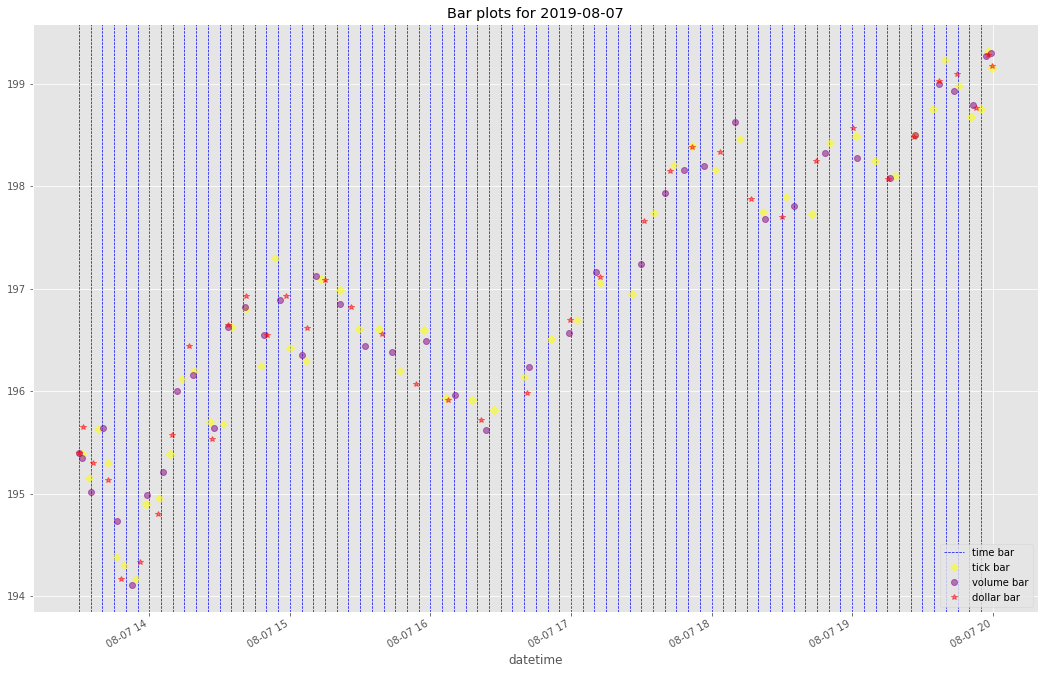

In [6]:
plot_bars(AAPL)

I have randomly choosen a date from the sample and ploted the alternative bars over the time bar as a reference. We can see some clustering at the start and end of the market hours this was expected as more orders are executed during this periods as a result more information is available. But time bar have note captured it due to its constant sampling frequency. 

In [7]:
#Statistical Tests
def get_statistics(bars:dict):
    res = []
    for bar in bars.keys():
        ret = bars[bar].close.pct_change()[1:]
        jb = stats.jarque_bera(ret)[0]
        kurt = stats.kurtosis(ret)
        skew = stats.skew(ret)
        mean = ret.mean()
        std = ret.std()
        res.append([mean, std, skew, kurt, jb])
    return pd.DataFrame(res, index=bars.keys(), 
                        columns=['mean', 'std', 'skew', 'kurtosis','jarque-bera stats'])

In [8]:
get_statistics(AAPL)

,mean,std,skew,kurtosis,jarque-bera stats
time_bar,0.000016,0.001882,-2.477331,217.308188,7.685577e+07
tick_bar,0.000029,0.002567,-1.655085,121.617280,1.336102e+07
volume_bar,0.000033,0.002771,-1.400917,102.871253,8.262234e+06
dollar_bar,0.000036,0.002896,-1.323723,95.455645,6.481939e+06


Here we see some important statistics for different bars returns. The dollar bar has the best statistics among all, especially has the lowest Jarque Bera stats and kurtosis. Also, the time bars has least attractive stats among all.

In [9]:
##ACF Plots 
def plot_bar_acf(bars:dict, lags:int=120):
    fig, axes = plt.subplots(2, 2, figsize=(20,15))
    loc = [(0,0), (0,1), (1,0), (1,1)]
    for i, bar in enumerate(bars.keys()):
        ret = bars[bar].close.pct_change()[1:]
        plot_acf(ret, lags=lags, zero=False, ax=axes[loc[i][0],loc[i][1]], title=f'{bar} Auto Correlation with {lags} lag')

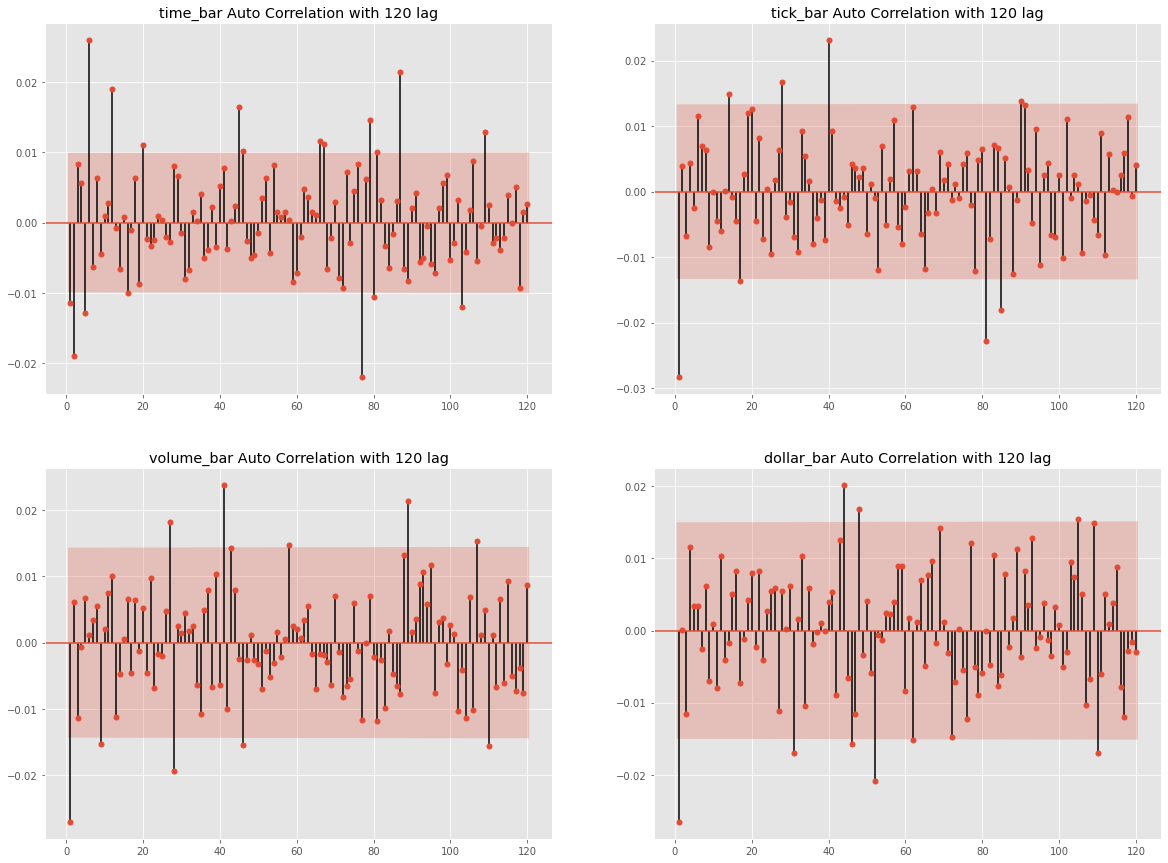

In [10]:
plot_bar_acf(AAPL)

In [11]:
##Serial Correlations/ Auto-Correlations 
def get_auto_corr(bars:dict):
    for bar in bars.keys():
        ret = bars[bar].close.pct_change()[1:]
        auto_corr = ret.autocorr(lag=1)
        print(f'Auto-correlations for {bar} with lag=1 is {auto_corr} ')

In [12]:
get_auto_corr(AAPL)

Auto-correlations for time_bar with lag=1 is -0.01144566799717028 
Auto-correlations for tick_bar with lag=1 is -0.028345363282703682 
Auto-correlations for volume_bar with lag=1 is -0.027059486204423024 
Auto-correlations for dollar_bar with lag=1 is -0.02654303523363807 


There is no auto-correlation in any of the given bars. 

In [13]:
#Distribution Plot
def plot_return_distributions(bars:dict):
    f,ax=plt.subplots(figsize=(14,10))
    for bar in bars.keys():
        ret = bars[bar].close.pct_change()[1:]
        #normalize the returns 
        norm_ret = (ret - ret.mean()) / ret.std()
        sns.kdeplot(norm_ret, label=bar)
    sns.kdeplot(np.random.normal(size=100000), label="Normal", color='black', linestyle="--")
    plt.title('Bar Returns KDE Plots')
    plt.xticks(range(-5, 6))
    plt.legend(loc=8, ncol=5)
    plt.xlim(-5, 5)
    plt.show()

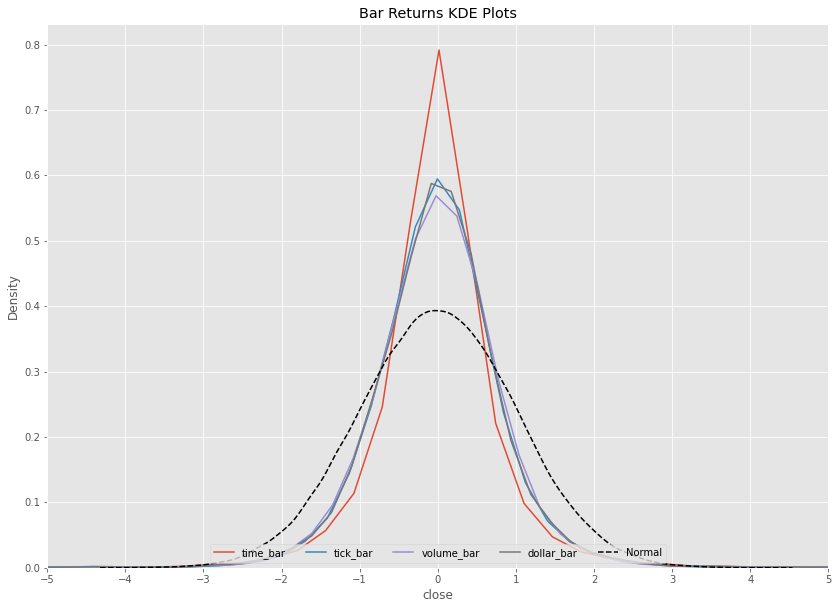

In [14]:
plot_return_distributions(AAPL)

From the above plot we see a partial recovery to normality for the alternative bars comapred to the time bars. The normal distribution is shown with the dotted black line in the above graph. 

## Conclusion

From the above analysis, we conclude that alternative bars are promising and have attractive properties compared to time bar. But the only factor that affects the bars is its threshold or sampling frequency, a change threshold can bring significant changes in its properties. For analysis, I choose the thresholds arbitrarily, which should not be done if it is applied in practice. A good solution is to use a dynamic threshold (a threshold that keeps changing over time) as a function of a metric that can track market dynamics. Dr de Prado suggested using a function of the free-float market capitalization of stock as a dynamic threshold. A dynamic threshold will be used in the trading strategy of this article. Also, it is not the case that alternative bars always perform better than time bars. Whether to go with a time bar or volume bar or dollar bar depends on the problem we are trying to solve, blindly going with any one of those might lead to a suboptimal or poor result. Proper statistical tests as shown above should help to choose the right bar for the problem. For example, we want to capture the short-term momentum than we can think using dollar bars and volume bars as the most important factor affecting the short term momentum is trade volume. A second example would explain or capture seasonality in the market, time-bar seems to the go-to candidate.


**Key Takeaways:** <br>

- Alternatives bars properties are dependent on the threshold used for sampling.
- Use dynamic threshold while applying alternative bars in practice.
- Choosing the right type of bars depends on the problem we are solving.
- Statistical tests as above might help to choose the right bar for the problem.
- Alternative bars shine well with machine learning models.

Finally, I would like say that feel free playing with this notebook with different securities and compare the results. You may also refer the sources given below - 

- https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Tick%2C%20Volume%2C%20Dollar%20Volume%20Bars.ipynb
- https://mlfinlab.readthedocs.io/en/latest/implementations/data_structures.html